In [71]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }"))

### a) Após a transferência, verificação dos arquivos no o HDFS:

In [175]:
!hdfs dfs -ls /user/claudio/covid19

Found 4 items
-rw-r--r--   3 root supergroup   62492959 2022-09-06 03:31 /user/claudio/covid19/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup   76520681 2022-09-06 03:31 /user/claudio/covid19/HIST_PAINEL_COVIDBR_2020_Parte2_06jul2021.csv
-rw-r--r--   3 root supergroup   91120916 2022-09-06 03:31 /user/claudio/covid19/HIST_PAINEL_COVIDBR_2021_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup    3046774 2022-09-06 03:31 /user/claudio/covid19/HIST_PAINEL_COVIDBR_2021_Parte2_06jul2021.csv


### b) Verificação utilizando o primeiro arquivo:

In [177]:
!hdfs dfs -cat /user/claudio/covid19/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv | head -n 4





cat: Unable to write to output stream.


### c) Definição do Schema:

In [4]:
from pyspark.sql.types import StructType

t_schema = StructType().add("regiao", "string").\
                        add("estado", "string").\
                        add("municipio", "string").\
                        add("coduf", "integer").\
                        add("codmun", "integer").\
                        add("codRegiaoSaude", "integer").\
                        add("nomeRegiaoSaude", "string").\
                        add("data", "date").\
                        add("semanaEp", "integer").\
                        add("populacaoTCU2019", "long").\
                        add("casosAcumulado", "long").\
                        add("casosNovos", "integer").\
                        add("obitosAcumulado", "long").\
                        add("obitosNovos", "integer").\
                        add("Recuperadosnovos", "integer").\
                        add("emAcompanhamentoNovos", "integer").\
                        add("interior/metropolitana", "string")
print(t_schema)

StructType(List(StructField(regiao,StringType,true),StructField(estado,StringType,true),StructField(municipio,StringType,true),StructField(coduf,IntegerType,true),StructField(codmun,IntegerType,true),StructField(codRegiaoSaude,IntegerType,true),StructField(nomeRegiaoSaude,StringType,true),StructField(data,DateType,true),StructField(semanaEp,IntegerType,true),StructField(populacaoTCU2019,LongType,true),StructField(casosAcumulado,LongType,true),StructField(casosNovos,IntegerType,true),StructField(obitosAcumulado,LongType,true),StructField(obitosNovos,IntegerType,true),StructField(Recuperadosnovos,IntegerType,true),StructField(emAcompanhamentoNovos,IntegerType,true),StructField(interior/metropolitana,StringType,true)))


### d) Trazendo os dados dos arquivos utilizando o Schema pré-definido e realizando a contagem inicial:

In [8]:
df = spark.read.schema(t_schema).csv("/user/claudio/covid19/HIST_PAINEL_COVIDBR_202*.csv", header=True, sep=";")

print( df.show(4,False), f"TOTAL:{ df.count() }") 

+------+------+---------+-----+------+--------------+---------------+----------+--------+----------------+--------------+----------+---------------+-----------+----------------+---------------------+----------------------+
|regiao|estado|municipio|coduf|codmun|codRegiaoSaude|nomeRegiaoSaude|data      |semanaEp|populacaoTCU2019|casosAcumulado|casosNovos|obitosAcumulado|obitosNovos|Recuperadosnovos|emAcompanhamentoNovos|interior/metropolitana|
+------+------+---------+-----+------+--------------+---------------+----------+--------+----------------+--------------+----------+---------------+-----------+----------------+---------------------+----------------------+
|Brasil|null  |null     |76   |null  |null          |null           |2020-02-25|9       |210147125       |0             |0         |0              |0          |null            |null                 |null                  |
|Brasil|null  |null     |76   |null  |null          |null           |2020-02-26|9       |210147125       |1 

### e) Definição do banco de dados:

In [9]:
spark.catalog.setCurrentDatabase("br_covid19_2020_2021")
from pyspark.sql import HiveContext
sql_context = HiveContext(sc)

### f) Criação da tabela Raw:

In [16]:
sql_context.sql("CREATE EXTERNAL TABLE IF NOT EXISTS covid19_externa(\
                    regiao string, estado string, municipio string, coduf integer, codmun integer, \
                    codRegiaoSaude integer, nomeRegiaoSaude string, data date, semanaEp integer, \
                    populacaoTCU2019 long, casosAcumulado long, casosNovos integer, obitosAcumulado long, \
                    obitosNovos integer, Recuperadosnovos integer, emAcompanhamentoNovos integer, \
                    interior_metropolitana string) \
                    row format delimited fields terminated by ';' \
                    lines terminated by '\n' location '/user/claudio/covid19/' \
                    tblproperties('skip.header.line.count'='1')" )

DataFrame[]

In [17]:
spark.sql("show tables").show(10,False)

+--------------------+---------------+-----------+
|database            |tableName      |isTemporary|
+--------------------+---------------+-----------+
|br_covid19_2020_2021|covid19_externa|false      |
+--------------------+---------------+-----------+



### g) Verificação da maior e menor data:

In [22]:
from pyspark.sql.functions import col

ext_df = sql_context.sql('SELECT MIN(data) data_ini , MAX(data) data_fim FROM covid19_externa') 
ext_df.show()
#print( ext_df.orderBy( col("data").asc()).select('data').show(1) , ext_df.orderBy( col("data").desc()).select('data').show(1))

+----------+----------+
|  data_ini|  data_fim|
+----------+----------+
|2020-02-25|2021-07-06|
+----------+----------+



### h) Com a última data de envio '2021-07-06', recupera-se somente as linhas que contém a totalização por Região:

In [34]:
%%time

data_ini = '2021-07-06'

sql_context.sql(f'SELECT regiao, estado, casosAcumulado, obitosAcumulado, populacaoTCU2019\
                    FROM covid19_externa \
                   WHERE (data="{data_ini}") AND (municipio ="") AND (populacaoTCU2019 IS NOT NULL)').show(40,False)

+------------+------+--------------+---------------+----------------+
|regiao      |estado|casosAcumulado|obitosAcumulado|populacaoTCU2019|
+------------+------+--------------+---------------+----------------+
|Brasil      |      |18855015      |526892         |210147125       |
|Norte       |RO    |251977        |6226           |1777225         |
|Norte       |AC    |85997         |1760           |881935          |
|Norte       |AM    |405066        |13349          |4144597         |
|Norte       |RR    |113758        |1763           |605761          |
|Norte       |PA    |557708        |15624          |8602865         |
|Norte       |AP    |118066        |1857           |845731          |
|Norte       |TO    |200243        |3266           |1572866         |
|Nordeste    |MA    |322052        |9190           |7075181         |
|Nordeste    |PI    |299084        |6662           |3273227         |
|Nordeste    |CE    |894678        |22791          |9132078         |
|Nordeste    |RN    

### i) Contagem inicial - Verificando os totais por Região, calculando a incidência e a mortandade:

In [124]:
%%time
_100kHab = 100000  # A cada 100 mil habitantes

regiao_df = sql_context.sql(f"SELECT Regiao, Casos, Obitos, \
                                     ((Casos/pop) *'{_100kHab}') AS Incidencia, \
                                     ((Obitos/pop)*'{_100kHab}') AS Mortalidade \
                                FROM ( \
                                       SELECT Regiao, \
                                              SUM(casosAcumulado) AS Casos,\
                                              SUM(obitosAcumulado) AS Obitos,\
                                              SUM(populacaoTCU2019) AS pop \
                                         FROM covid19_externa \
                                        WHERE data='{data_ini}' \
                                          AND municipio ='' \
                                          AND populacaoTCU2019 is not null \
                                     GROUP BY Regiao \
                                     ) \
                            ORDER BY Regiao")

regiao_df.show(10)

+------------+--------+------+------------------+------------------+
|      Regiao|   Casos|Obitos|        Incidencia|       Mortalidade|
+------------+--------+------+------------------+------------------+
|      Brasil|18855015|526892| 8972.292625940041|250.72529543290204|
|Centro-Oeste| 1916619| 49207|11760.509892757436| 301.9376361670813|
|    Nordeste| 4455737|107824| 7807.268035371816|188.92741394878797|
|       Norte| 1732815| 43845| 9401.643320105604|237.88751330640042|
|     Sudeste| 7138803|245311| 8078.179517582339| 277.5908363961915|
|         Sul| 3611041| 80705|12046.446915637533| 269.2321960139824|
+------------+--------+------+------------------+------------------+

CPU times: user 2.92 ms, sys: 1.27 ms, total: 4.19 ms
Wall time: 5.51 s


### j) Formatando conforme a visão do Site (Tranformação do Dataframe):

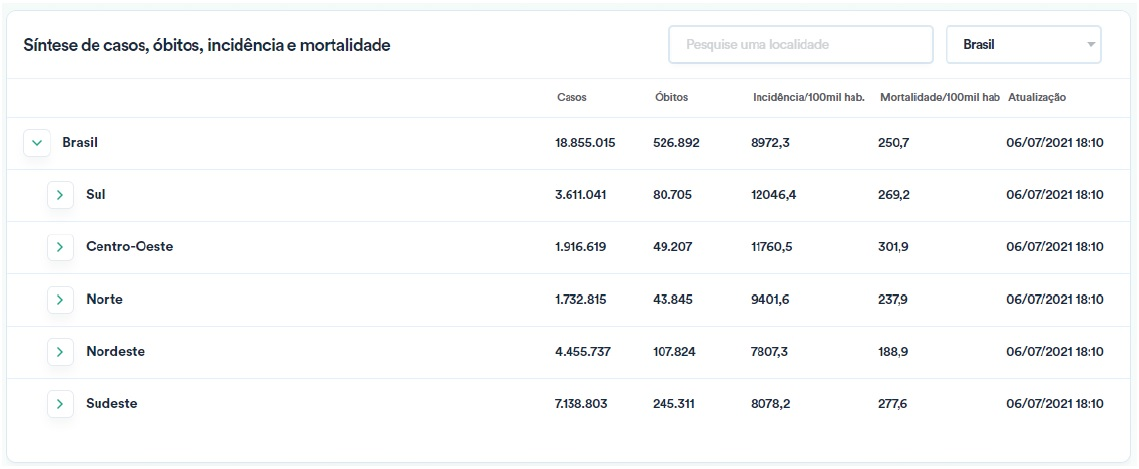

In [59]:
from pyspark.sql.functions import col, lit, format_number ,translate, date_format, from_unixtime, unix_timestamp

In [133]:
def _format(value, dec=0):
    return translate( format_number(value, dec), ",.", ".,")

In [134]:
%%time
regiao_df.withColumn("Incidencia" , lit(_format( col("Incidencia"),1) )) \
         .withColumn("Mortalidade", lit(_format( col("Mortalidade"),1) )) \
         .withColumn("Casos",       lit(_format( col("Casos")) )) \
         .withColumn("Obitos",      lit(_format( col("Obitos")) )) \
         .withColumnRenamed("Incidencia", "Incidencia/100MilHab")   \
         .withColumnRenamed("Mortalidade", "Mortalidade/100MilHab") \
         .withColumn("Atualizacao", from_unixtime( unix_timestamp(lit(data_ini), 'yyyy-MM-dd'), 'dd/MM/yyyy'))\
         .drop("pop").show()

+------------+----------+-------+--------------------+---------------------+-----------+
|      Regiao|     Casos| Obitos|Incidencia/100MilHab|Mortalidade/100MilHab|Atualizacao|
+------------+----------+-------+--------------------+---------------------+-----------+
|      Brasil|18.855.015|526.892|             8.972,3|                250,7| 06/07/2021|
|Centro-Oeste| 1.916.619| 49.207|            11.760,5|                301,9| 06/07/2021|
|    Nordeste| 4.455.737|107.824|             7.807,3|                188,9| 06/07/2021|
|       Norte| 1.732.815| 43.845|             9.401,6|                237,9| 06/07/2021|
|     Sudeste| 7.138.803|245.311|             8.078,2|                277,6| 06/07/2021|
|         Sul| 3.611.041| 80.705|            12.046,4|                269,2| 06/07/2021|
+------------+----------+-------+--------------------+---------------------+-----------+

CPU times: user 10.9 ms, sys: 4.61 ms, total: 15.5 ms
Wall time: 3.96 s


### k) Gerando a segunda visão conforme o Site (Transformação do Dataframe):
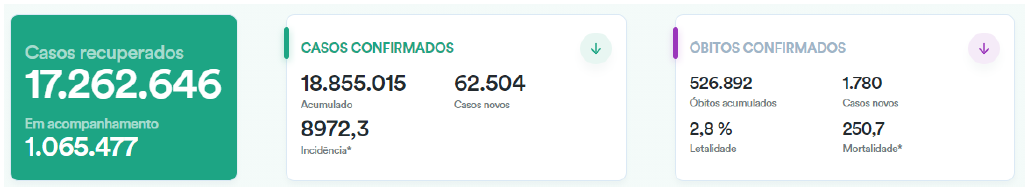

In [107]:
%%time
brasil = sql_context.sql(f"SELECT Recuperadosnovos AS CasosRecuperados,\
                                  emAcompanhamentoNovos AS EmAcompanhamento, \
                                  casosAcumulado AS Acumulado, \
                                  casosNovos AS CasosNMovos, \
                                  ((casosAcumulado/populacaoTCU2019)*'{_100kHab}') AS Incidencia, \
                                  obitosAcumulado AS ObtosAcumulados, \
                                  obitosNovos AS ObtosNovos, \
                                  ((obitosAcumulado/casosAcumulado)*100) AS Letalidade, \
                                  ((obitosAcumulado/populacaoTCU2019)*'{_100kHab}') AS Mortalidade \
                             FROM covid19_externa \
                            WHERE (regiao='Brasil') AND (data='{data_ini}')" ) 

CPU times: user 1.45 ms, sys: 655 µs, total: 2.1 ms
Wall time: 24.8 ms


In [135]:
%%time
brasil.withColumn("CasosRecuperados" ,lit(_format( col("CasosRecuperados")) )) \
      .withColumn("EmAcompanhamento", lit(_format( col("EmAcompanhamento")) )) \
      .withColumn("Acumulado" ,       lit(_format( col("Acumulado")) )) \
      .withColumn("CasosNMovos",      lit(_format( col("CasosNMovos")) )) \
      .withColumn("Incidencia" ,      lit(_format( col("Incidencia"),1) )) \
      .withColumn("ObtosAcumulados",  lit(_format( col("ObtosAcumulados")) )) \
      .withColumn("ObtosNovos",       lit(_format( col("ObtosNovos")) )) \
      .withColumn("Letalidade",       lit(_format( col("Letalidade"),1) )) \
      .withColumn("Mortalidade",      lit(_format( col("Mortalidade"),1) )).show(5)                                   

+----------------+----------------+----------+-----------+----------+---------------+----------+----------+-----------+
|CasosRecuperados|EmAcompanhamento| Acumulado|CasosNMovos|Incidencia|ObtosAcumulados|ObtosNovos|Letalidade|Mortalidade|
+----------------+----------------+----------+-----------+----------+---------------+----------+----------+-----------+
|      17.262.646|       1.065.477|18.855.015|     62.504|   8.972,3|        526.892|     1.780|       2,8|      250,7|
+----------------+----------------+----------+-----------+----------+---------------+----------+----------+-----------+

CPU times: user 5.37 ms, sys: 30 ms, total: 35.3 ms
Wall time: 11 s


### l) Exemplo de criação de uma tabela no formato Perquet compressão Snappy a partir da tabela externa.
#### Selecionando alguns campos relevantes trazendo os campos nulos tratados:

In [149]:
%%time
df2 = sql_context.sql(f"SELECT regiao, estado, municipio, data, populacaoTCU2019, casosAcumulado, casosNovos, \
                              obitosAcumulado, obitosNovos, NVL(Recuperadosnovos,0) Recuperadosnovos\
                         FROM covid19_externa \
                        WHERE (data='{data_ini}') AND (populacaoTCU2019 IS NOT NULL)")
df2.show(4)

+------+------+---------+----------+----------------+--------------+----------+---------------+-----------+----------------+
|regiao|estado|municipio|      data|populacaoTCU2019|casosAcumulado|casosNovos|obitosAcumulado|obitosNovos|Recuperadosnovos|
+------+------+---------+----------+----------------+--------------+----------+---------------+-----------+----------------+
|Brasil|      |         |2021-07-06|       210147125|      18855015|     62504|         526892|       1780|        17262646|
| Norte|    RO|         |2021-07-06|         1777225|        251977|       -47|           6226|         13|               0|
| Norte|    AC|         |2021-07-06|          881935|         85997|        14|           1760|          3|               0|
| Norte|    AM|         |2021-07-06|         4144597|        405066|       719|          13349|          0|               0|
+------+------+---------+----------+----------------+--------------+----------+---------------+-----------+----------------+


#### O campo 'populacaoTCU2019' preenchido indica a linha com os totais calculados pela última dada enviada:

In [151]:
%%time
df2.write\
   .mode("overwrite")\
   .format('Parquet')\
   .partitionBy("regiao","estado")\
   .option("compression","snappy")\
   .option("parquetSchema", df2.schema.simpleString)\
   .saveAsTable("covid19ParquetSnappy")

CPU times: user 6.58 ms, sys: 2.8 ms, total: 9.38 ms
Wall time: 10.2 s


### m) Comparando os dados com a tabela externa:

In [173]:
%%time
sql_context.sql(f"SELECT regiao, estado, municipio, data, populacaoTCU2019, casosAcumulado, casosNovos, \
                         obitosAcumulado, obitosNovos, Recuperadosnovos \
                    FROM covid19_externa \
                   WHERE (data='{data_ini}') AND (populacaoTCU2019 IS NOT NULL)\
                     AND regiao='Sudeste'\
                     AND estado='SP'\
                ORDER BY municipio").show(3)

+-------+------+----------+----------+----------------+--------------+----------+---------------+-----------+----------------+
| regiao|estado| municipio|      data|populacaoTCU2019|casosAcumulado|casosNovos|obitosAcumulado|obitosNovos|Recuperadosnovos|
+-------+------+----------+----------+----------------+--------------+----------+---------------+-----------+----------------+
|Sudeste|    SP|          |2021-07-06|        45919049|       3809222|     19132|         130389|        714|            null|
|Sudeste|    SP|Adamantina|2021-07-06|           35068|          3441|        20|            110|          0|            null|
|Sudeste|    SP|    Adolfo|2021-07-06|            3562|           537|         3|             14|          0|            null|
+-------+------+----------+----------+----------------+--------------+----------+---------------+-----------+----------------+
only showing top 3 rows

CPU times: user 3.91 ms, sys: 1.64 ms, total: 5.54 ms
Wall time: 6.09 s


In [174]:
%%time
sql_context.sql(f"SELECT regiao, estado, municipio, data, populacaoTCU2019, casosAcumulado, casosNovos, \
                         obitosAcumulado, obitosNovos, Recuperadosnovos \
                    FROM covid19ParquetSnappy \
                   WHERE regiao='Sudeste'\
                     AND estado='SP'\
                ORDER BY municipio").show(3)

+-------+------+----------+----------+----------------+--------------+----------+---------------+-----------+----------------+
| regiao|estado| municipio|      data|populacaoTCU2019|casosAcumulado|casosNovos|obitosAcumulado|obitosNovos|Recuperadosnovos|
+-------+------+----------+----------+----------------+--------------+----------+---------------+-----------+----------------+
|Sudeste|    SP|          |2021-07-06|        45919049|       3809222|     19132|         130389|        714|               0|
|Sudeste|    SP|Adamantina|2021-07-06|           35068|          3441|        20|            110|          0|               0|
|Sudeste|    SP|    Adolfo|2021-07-06|            3562|           537|         3|             14|          0|               0|
+-------+------+----------+----------+----------------+--------------+----------+---------------+-----------+----------------+
only showing top 3 rows

CPU times: user 2.17 ms, sys: 911 µs, total: 3.09 ms
Wall time: 172 ms


### n) Verificando a estrutura e as partições:

In [148]:
spark.sql("show tables").show(8,False)
spark.sql('describe covid19ParquetSnappy').show(50,False)
spark.sql("show partitions covid19parquetsnappy").show(100,False)

+--------------------+--------------------+-----------+
|database            |tableName           |isTemporary|
+--------------------+--------------------+-----------+
|br_covid19_2020_2021|covid19_externa     |false      |
|br_covid19_2020_2021|covid19parquetsnappy|false      |
+--------------------+--------------------+-----------+

+-----------------------+---------+-------+
|col_name               |data_type|comment|
+-----------------------+---------+-------+
|municipio              |string   |null   |
|data                   |date     |null   |
|populacaoTCU2019       |bigint   |null   |
|casosAcumulado         |bigint   |null   |
|casosNovos             |int      |null   |
|obitosAcumulado        |bigint   |null   |
|obitosNovos            |int      |null   |
|Recuperadosnovos       |int      |null   |
|regiao                 |string   |null   |
|estado                 |string   |null   |
|# Partition Information|         |       |
|# col_name             |data_type|comment|
|re

### o) Verificando o diretório a tabela Parquet:

In [152]:
%%time
!hdfs dfs -ls /user/hive/warehouse/br_covid19_2020_2021.db/
!hdfs dfs -ls /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy

Found 1 items
drwxr-xr-x   - root supergroup          0 2022-10-10 23:10 /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy
Found 7 items
-rw-r--r--   2 root supergroup          0 2022-10-10 23:10 /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy/_SUCCESS
drwxr-xr-x   - root supergroup          0 2022-10-10 23:10 /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy/regiao=Brasil
drwxr-xr-x   - root supergroup          0 2022-10-10 23:10 /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy/regiao=Centro-Oeste
drwxr-xr-x   - root supergroup          0 2022-10-10 23:10 /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy/regiao=Nordeste
drwxr-xr-x   - root supergroup          0 2022-10-10 23:10 /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy/regiao=Norte
drwxr-xr-x   - root supergroup          0 2022-10-10 23:10 /user/hive/warehouse/br_covid19_2020_2021.db/covid19parquetsnappy/regiao=Sudeste
drwxr-xr-x